In [35]:
%matplotlib inline
import matplotlib.pyplot
import seaborn as sns
import os
sns.set(rc={'figure.figsize':(15,6)})
import pandas as pd
import numpy as np

In [101]:
abs_path = os.getcwd()
events_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/event_data_train.zip', compression='zip')
submissions_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/submissions_data_train.zip', compression='zip')


In [37]:
events_data.head()
submissions_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [38]:
events_data.action.unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

In [39]:
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')
submissions_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')

In [40]:
events_data.head()

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35


In [41]:
events_data.dtypes

step_id               int64
timestamp             int64
action               object
user_id               int64
date         datetime64[ns]
dtype: object

In [42]:
events_data.date.max()

Timestamp('2018-05-19 23:33:31')

In [43]:
events_data['day'] = events_data.date.dt.date
submissions_data['day'] = events_data.date.dt.date

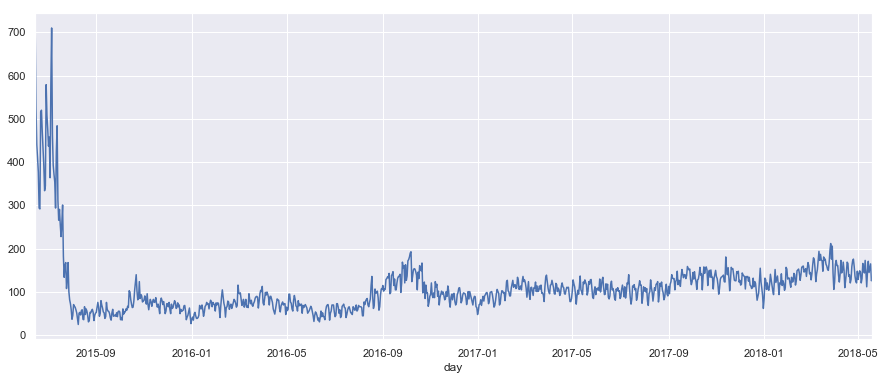

In [44]:
events_data.groupby('day').user_id.nunique().plot()

In [45]:
# events_data[events_data.action == 'passed'] \
# .groupby('user_id', as_index=False) \
# .agg({'step_id': 'count'}) \
# .rename(columns={'step_id': 'passed_steps'}).passed_steps.hist()


In [46]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [81]:
user_events_data = events_data.pivot_table(index='user_id', columns='action', values='step_id',
                        aggfunc='count', fill_value=0).reset_index()

In [82]:
user_events_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


In [62]:
user_scores = submissions_data.pivot_table(index='user_id', columns='submission_status', values='step_id',
                        aggfunc='count', fill_value=0).sort_values(['correct'], ascending=False ).reset_index()

In [63]:
gap_data = events_data[['user_id','day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
.groupby('user_id')['timestamp'].apply(list).apply(np.diff).values

In [64]:
gap_data = pd.Series(np.concatenate(gap_data, axis=0))

In [65]:
gap_data = gap_data/(20*60*60)

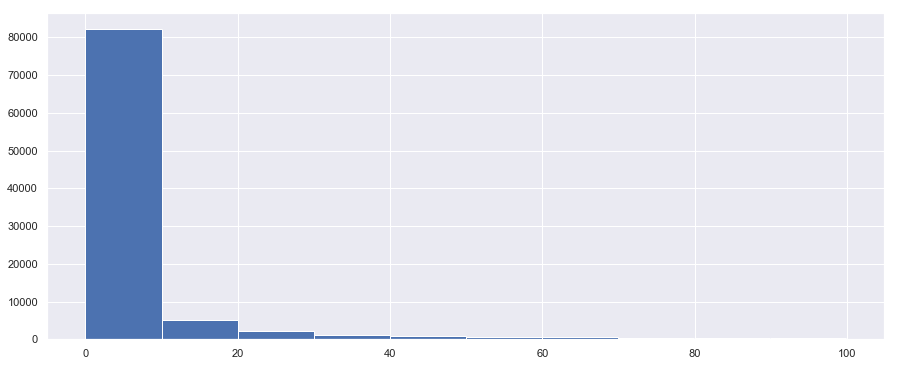

In [66]:
gap_data[gap_data <100].hist()

In [67]:
gap_data.quantile(0.90)

21.99119444444448

In [68]:
events_data.tail()

,step_id,timestamp,action,user_id,date,day
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19
3480702,33892,1526772811,viewed,18526,2018-05-19 23:33:31,2018-05-19


In [69]:
user_data = events_data.groupby('user_id', as_index=False)\
.agg({'timestamp':'max'}).rename(columns={'timestamp':'last_timestamp'})

In [70]:
now = 1526772811
drop_ts = 2592000

In [71]:
user_data['is_gone_user'] = (now - user_data.last_timestamp) > drop_ts

In [72]:
user_data.head()

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


In [73]:
user_scores.head()

submission_status,user_id,correct,wrong
0,1046,421,513
1,5552,186,93
2,17135,168,177
3,6183,142,65
4,8461,135,42


In [79]:
user_data = user_data.merge(user_scores,on='user_id',how='outer').fillna(0)

In [83]:
user_data = user_data.merge(user_events_data,on='user_id',how='outer').fillna(0)

In [85]:
user_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,0.0,0.0,1,0,0,1
1,2,1519226966,True,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,91,87,30,192
3,5,1499859939,True,2.0,2.0,11,11,4,12
4,7,1521634660,True,0.0,0.0,1,1,0,1


In [89]:
user_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()

In [90]:
user_days.head()

,user_id,day
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1


In [91]:
user_data = user_data.merge(user_days,on='user_id',how='outer').fillna(0)

In [92]:
user_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1


In [93]:
user_data.user_id.count()

19234

In [95]:
events_data.user_id.nunique()

19234

In [96]:
user_data['passed_course'] = user_data.passed > 170

In [97]:
user_data.groupby('passed_course').count()


,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
passed_course,,,,,,,,,,
False,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809
True,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425
